In [4]:
from langgraph.graph import StateGraph, START, END
from typing import Dict, Any

# --- 1. State 정의 ---
from state import AgentState

# --- 2. 노드 함수 임포트 ---

# 2-1. 시작 및 분기 노드
from query_analysis import generate_query_analysis, route_query_type

# 2-2. 기능 1: 특정 검색 (Specific Search)
# (format_state_to_string, generate_rag_query, retrieve, generate_answer)
from specific_search import *

# 2-3. 기능 2: 유사 추천 (Similar Recommendation)
from similar_recommendation import (
    retrieve_and_update_rag_context,
    generate_recommendation_query
)

# 2-4. 기능 3: 광범위 추천 (Broad Recommendation)
from broad_recommendation import (
    generate_broad_rag_query,
    retrieve_with_filter
)

In [5]:
def build_graph() -> StateGraph:
    """
    전체 RAG 워크플로우를 위한 LangGraph를 빌드합니다.
    """
    
    builder = StateGraph(AgentState)

    # --- 3. 노드 추가 ---

    # 3-1. 시작점 (쿼리 분석)
    builder.add_node("generate_query_analysis", generate_query_analysis)

    # 3-2. 기능 1 (Specific Search) 브랜치 노드
    # 이 브랜치는 1(format) -> 2(gen_query) -> 3(retrieve) -> 4(answer)
    builder.add_node("format_state_specific", format_state_to_string)
    builder.add_node("generate_rag_query_specific", generate_rag_query)
    builder.add_node("retrieve_specific", retrieve)

    # 3-3. 기능 2 (Similar Recommendation) 브랜치 노드
    # 이 브랜치는 1(format) -> 2(gen_query) -> 3(retrieve_base) -> 4(gen_rec_query) -> 5(retrieve_similar) -> 6(answer)
    builder.add_node("format_state_similar", format_state_to_string)
    builder.add_node("generate_rag_query_base", generate_rag_query) # 재사용
    builder.add_node("retrieve_base_item", retrieve_and_update_rag_context)
    builder.add_node("generate_recommend_query", generate_recommendation_query)
    builder.add_node("retrieve_similar_items", retrieve) # 재사용

    # 3-4. 기능 3 (Broad Recommendation) 브랜치 노드
    # 이 브랜치는 1(format) -> 2(gen_broad_query) -> 3(retrieve_filtered) -> 4(answer)
    builder.add_node("format_state_broad", format_state_to_string)
    builder.add_node("generate_broad_query", generate_broad_rag_query)
    builder.add_node("retrieve_filtered", retrieve_with_filter)

    # 3-5. 종료점 (공유 노드)
    builder.add_node("generate_answer", generate_answer)


    # --- 4. 엣지 연결 ---

    # 4-1. 시작점 및 조건부 분기
    # builder.set_entry_point("generate_query_analysis")
    builder.add_edge(START, "generate_query_analysis")
    
    builder.add_conditional_edges(
        "generate_query_analysis",  # 쿼리 분석 노드 이후에
        route_query_type,           # 이 함수를 실행하여
        {
            # 결과 문자열에 따라 다음 노드를 매핑
            "specific_search": "format_state_specific",
            "similar_recommendation": "format_state_similar",
            "broad_recommendation": "format_state_broad"
        }
    )

    # 4-2. 기능 1 (Specific) 브랜치 엣지
    builder.add_edge("format_state_specific", "generate_rag_query_specific")
    builder.add_edge("generate_rag_query_specific", "retrieve_specific")
    builder.add_edge("retrieve_specific", "generate_answer") # 답변 노드로 이동

    # 4-3. 기능 2 (Similar) 브랜치 엣지
    builder.add_edge("format_state_similar", "generate_rag_query_base")
    builder.add_edge("generate_rag_query_base", "retrieve_base_item")
    builder.add_edge("retrieve_base_item", "generate_recommend_query")
    builder.add_edge("generate_recommend_query", "retrieve_similar_items")
    builder.add_edge("retrieve_similar_items", "generate_answer") # 답변 노드로 이동

    # 4-4. 기능 3 (Broad) 브랜치 엣지
    builder.add_edge("format_state_broad", "generate_broad_query")
    builder.add_edge("generate_broad_query", "retrieve_filtered")
    builder.add_edge("retrieve_filtered", "generate_answer") # 답변 노드로 이동

    # 4-5. 종료점 설정
    builder.add_edge("generate_answer", END)
    
    # 5. 그래프 컴파일
    app = builder.compile()
    
    return app

In [6]:
app = build_graph()

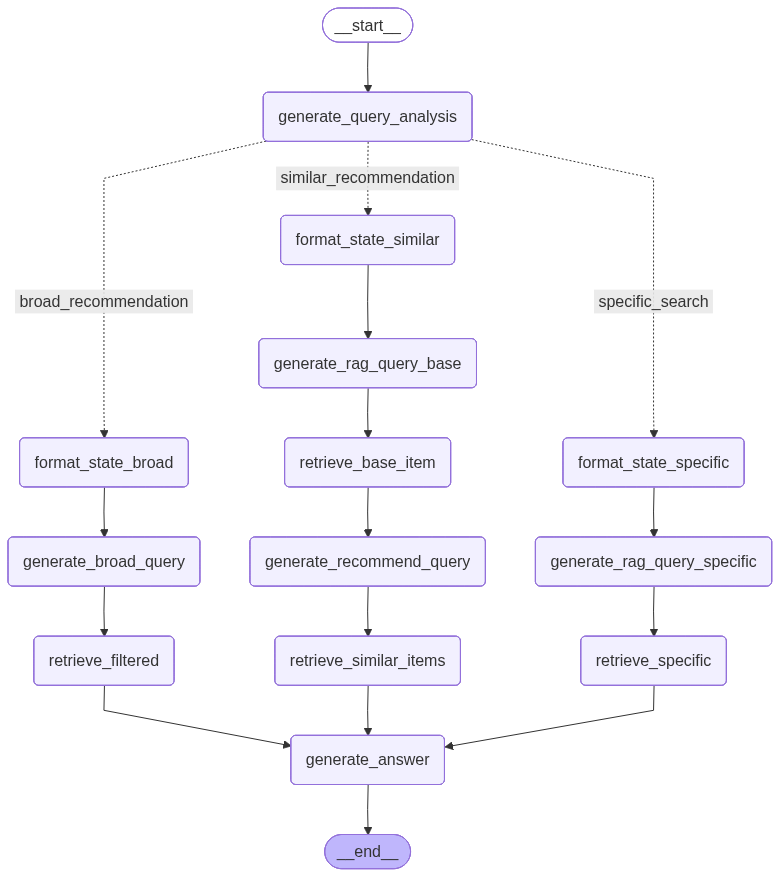

In [7]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))